In [107]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import platform
from scipy.spatial.distance import hamming, cosine, euclidean
import os
import cv2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score,classification_report

In [18]:
#Reading the CIFAR-10 dataset

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-python/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test


# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()


print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [20]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i], query_vector))
        
    return np.argsort(distances)[:top_n]

In [21]:
data=x_train.reshape(-1,3,32,32).transpose(0,2,3,1)

In [22]:
data.shape

(49000, 32, 32, 3)

In [103]:
#Saving images in vector for of shape (32,32,3)
with open('data_vectors.pickle', 'wb') as f:
            pickle.dump(data, f)

In [104]:
# infile = open('data_vectors.pickle','rb')
# x = pickle.load(infile)
# x.shape

(49000, 32, 32, 3)

In [136]:
data[0]*255

array([[[ 59.,  62.,  63.],
        [ 43.,  46.,  45.],
        [ 50.,  48.,  43.],
        ...,
        [158., 132., 108.],
        [152., 125., 102.],
        [148., 124., 103.]],

       [[ 16.,  20.,  20.],
        [  0.,   0.,   0.],
        [ 18.,   8.,   0.],
        ...,
        [123.,  88.,  55.],
        [119.,  83.,  50.],
        [122.,  87.,  57.]],

       [[ 25.,  24.,  21.],
        [ 16.,   7.,   0.],
        [ 49.,  27.,   8.],
        ...,
        [118.,  84.,  50.],
        [120.,  84.,  50.],
        [109.,  73.,  42.]],

       ...,

       [[208., 170.,  96.],
        [201., 153.,  34.],
        [198., 161.,  26.],
        ...,
        [160., 133.,  70.],
        [ 56.,  31.,   7.],
        [ 53.,  34.,  20.]],

       [[180., 139.,  96.],
        [173., 123.,  42.],
        [186., 144.,  30.],
        ...,
        [184., 148.,  94.],
        [ 97.,  62.,  34.],
        [ 83.,  53.,  34.]],

       [[177., 144., 116.],
        [168., 129.,  94.],
        [179., 1

In [23]:
batch_size = 64
num_classes = 10
epochs = 10

In [24]:
#BASE Model using VGG

image_size=32
vgg=VGG16(include_top=False,input_shape=(image_size,image_size,3))


model= Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation=('relu'),input_dim=512)) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax')))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [25]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate)
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [26]:
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
X_train = x_train.reshape(-1,3,32,32).transpose(0,2,3,1)
X_test = x_test.reshape(-1,3,32,32).transpose(0,2,3,1)
model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test))

Epoch 1/10
766/766 [==============================] - 886s 1s/step - loss: 1.1510 - accuracy: 0.6034 - val_loss: 0.7335 - val_accuracy: 0.7488
Epoch 2/10
766/766 [==============================] - 840s 1s/step - loss: 0.6702 - accuracy: 0.7764 - val_loss: 0.5964 - val_accuracy: 0.7989
Epoch 3/10
766/766 [==============================] - 840s 1s/step - loss: 0.5392 - accuracy: 0.8206 - val_loss: 0.6045 - val_accuracy: 0.7998
Epoch 4/10
766/766 [==============================] - 846s 1s/step - loss: 0.4426 - accuracy: 0.8528 - val_loss: 0.5547 - val_accuracy: 0.8184
Epoch 5/10
766/766 [==============================] - 853s 1s/step - loss: 0.3700 - accuracy: 0.8770 - val_loss: 0.5209 - val_accuracy: 0.8266
Epoch 6/10
766/766 [==============================] - 928s 1s/step - loss: 0.3096 - accuracy: 0.8980 - val_loss: 0.4815 - val_accuracy: 0.8453
Epoch 7/10
766/766 [==============================] - 890s 1s/step - loss: 0.2512 - accuracy: 0.9172 - val_loss: 0.4880 - val_accuracy: 0.8516

In [97]:
# #saving the trained model.
model.save('mymodel.hdf5')
# model = load_model('mymodel.hdf5')

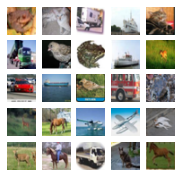

In [43]:
fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(data)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(data[i:i+1][0])

In [42]:
#The final model to generate feature_vectors of Images

reduced_model=Sequential()
for layer in model.layers[:-5]:
    reduced_model.add(layer)
reduced_model.add(Flatten())
reduced_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [44]:
data_features= reduced_model.predict(data).reshape(-1,512)

In [98]:
#Feature Vectors of Image Dataset
data_features.shape

(49000, 512)

In [99]:
#Saving the feature vectors
with open('cosine_train_vectors.pickle', 'wb') as f:
    pickle.dump(data_features, f)

In [102]:
# infile = open('cosine_train_vectors.pickle','rb')
# data_features = pickle.load(infile)
# data_features.shape

(49000, 512)

In [114]:
#Experimenting with uploaded image
image = cv2.imread('Test/airplane.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (32, 32), cv2.INTER_CUBIC)

In [120]:
image = image.reshape(-1,32,32,3)
image.shape

(1, 32, 32, 3)

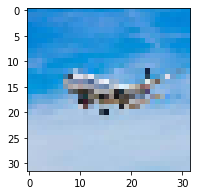

In [132]:
plt.figure(figsize=(3,3))
plt.imshow(image[0])

In [121]:
#Using the final model to generate feature vector for uploaded image

query = reduced_model.predict(image)
query.shape

(1, 512)

In [122]:
# The IDs for top 10 similar images are obtained by using cosime similarity as basie score.
closest_ids = cosine_distance(data_features, query, 10)

In [123]:
closest_ids

array([15153, 24163, 12073, 28865, 28449,  3184, 19282, 48653, 17247,
       28750])

In [ ]:
plt.figure(figsize = (3, 3))
plt.imshow(data[28865])